# Benchmark: MBR computation

Benchmark comparing Minimum Bounding Rectangle computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the Minimum Bounding Rectangle of the multi-polygon representing all districts of India a 100,000 times.

## WARNING

The analysis below shows that GEOS precomputes envolveop and is therefore faster...

# Prerequisites

Generate data:

```sh
cd harness
cargo run --release --bin benchmark_mbr -- --out-file ../analysis/benchmark_mbr/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson --iterations 100 --headlong
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_mbr/data.json
### Statistics: Raw data
               qps                                        
program        geo       geos geos_twice geos_twice_cloned
count    80.000000  80.000000  80.000000         80.000000
mean      4.881626   3.459848   1.733448          1.704453
std       1.223549   0.953661   0.451222          0.466740
min       2.157822   1.465633   0.883209          0.847777
25%       3.333208   2.029640   1.014250          1.012342
50%       5.675987   4.062728   2.000469          2.011537
75%       5.716429   4.103653   2.032523          2.035090
max       5.757167   4.205008   2.076041          2.061892


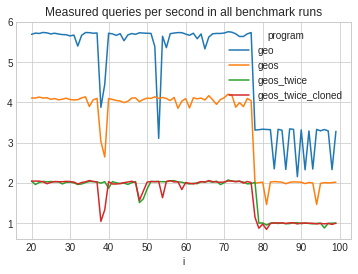

### Statistics: After outlier removal
               qps                                        
program        geo       geos geos_twice geos_twice_cloned
count    72.000000  72.000000  72.000000         72.000000
mean      5.139072   3.636286   1.815442          1.785548
std       0.985502   0.830710   0.397907          0.418843
min       3.108754   1.989315   0.883209          0.877207
25%       5.354605   3.878427   1.962428          1.756670
50%       5.693534   4.069009   2.010984          2.020634
75%       5.719661   4.107656   2.033528          2.035941
max       5.757167   4.205008   2.076041          2.061892


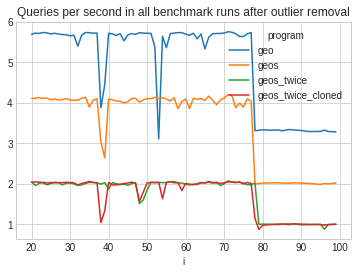

## Ratio of qps compared to geo
               qps                             
program       geos geos_twice geos_twice_cloned
count    72.000000  72.000000         72.000000
mean      0.703476   0.353697          0.345336
std       0.088451   0.059349          0.046509
min       0.594738   0.264178          0.263847
25%       0.681567   0.343108          0.318892
50%       0.715525   0.353908          0.354057
75%       0.720923   0.358036          0.357209
max       1.319528   0.654093          0.656739


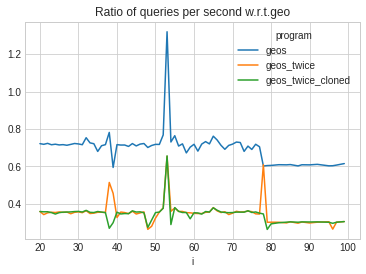

In [2]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb

# Performance benchmarking

To generate the following SVG:

```bash
cd harness
cargo build --release

perf record -F 100 -g --call-graph dwarf -o ../analysis/benchmark_mbr/perf.data -- ./target/release/benchmark_mbr --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 10 --headlong >/dev/null

cd ../analysis/benchmark_mbr
perf script -i perf.data | ../../third_party/stackcollapse-perf.pl > perf.collapsed-stacks.data
../../third_party/flamegraph.pl perf.collapsed-stacks.data > perf.svg
```

![](./perf.svg)

To dig in further, use
```
perf report -g -i perf.data
```

This shows that over 90% time is spent in `geo_types::private_utils::get_bounding_rect`.

In particular, `getEnvelope` in `libgeos` contributes ~0.13% time: ![](./ReportGetEnvelope.png)

-> My assumption that geo is losing out due to bad memory allocations is wrong.

## It's all just destructors

I didn't hvae geos with debugging information. Much better flamegraph once we have that:
 
![](./perf2.svg)

But somehow, geos became **slower** than geo. (should retry without debugsyms again) Verified that geos is still built with `-O2`.

Also, all the time being measured in geos is just destructors. See `./perf.hist.0`.

![](./only-distructors.png)


# gdb

Verified with gdb that:

* computeEnvelopeInternal is hit _before_ measurement, and never during measurement.
* It is hit when I compute the envelope to print it out.
  * It seems that the cached envelope is cloned with `Clone`. Kind of expected in retrospect, eh?


Next things to try:
* Tweak harness so that the variables are not dropped during measurement.
* Tweak benchmark_mbr so that it `Clone`s **before** computing envelope.
  * Verify with gdb that computeEnvelopeInternal is hit in the measurement.

![](./envelope_outside_harness.png)


# No more destructors

After ensuring that values aren't dropped while being measured:

* QPS doubled for all
* runtime ratio stayed unchanged
* callgraphs look better:
![](./NoMoreDestruction.png)


# It's all just allocations!

* On re-introducing computeEnvelopeInternal, the ratio didn't change much. So most of the time is spent in allocating geometries.

![](hurray.png)